# Exercises - lecture 6

In [10]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

In [2]:
figsizesmall = (8,6)
figuresize = (10,6)
figsizelarge = (15,10) 

## Interpolation

Ideally, use your own data and try out the different interpolation schemes, measure the time it takes and present it in the tutorial.
If you do not have any data use the data provided in the interpolation.txt

### Numpy interpolation

In [5]:
df_binding_coeff = pd.read_excel(r"C:\Users\admin\Desktop\PhD\Experimente\Project 2 with Mahesh\20231122 tLett binding coeff no-Eco2 less DFHBI-1T\20231122_results.xlsx",
                                sheet_name ="Tabelle1")
df_binding_coeff

,conc DNA,Rep 1,Rep 2,Rep 3,Average,STDEV
0,0.001,1164,1206,2914,1761.333333,998.459480
1,0.005,970,906,769,881.666667,102.685604
2,0.010,595,643,458,565.333333,96.001736
3,0.025,884,1139,956,993.000000,131.464824
4,0.050,1958,2066,1844,1956.000000,111.013513
5,0.100,5758,6083,5479,5773.333333,302.291802
6,0.250,21157,21447,21564,21389.333333,209.538382
7,0.500,39438,43058,42953,41816.333333,2060.366068
8,1.000,64301,66777,63329,64802.333333,1777.829388
9,2.500,84197,85556,84395,84716.000000,734.166875


In [7]:
inter_binding_conc = np.linspace(0, 10, 1000)
inter_binding_np = np.interp(inter_binding_conc, df_binding_coeff["conc DNA"],
                            df_binding_coeff["Average"])

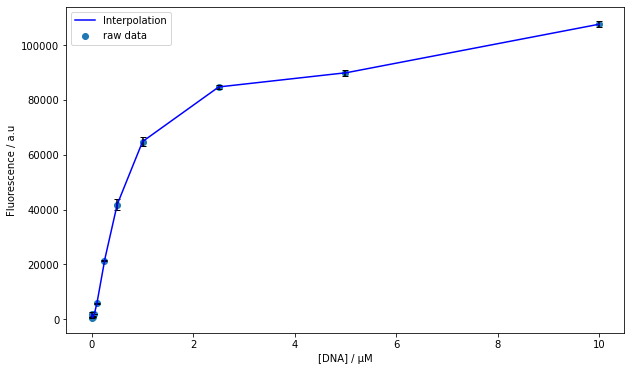

In [9]:
plt.figure(figsize=figuresize)

plt.scatter(df_binding_coeff["conc DNA"], df_binding_coeff["Average"], 
            label = "raw data")
plt.errorbar(df_binding_coeff["conc DNA"], df_binding_coeff["Average"], 
             yerr=df_binding_coeff["STDEV"], linestyle ="None", color="Black",
            capsize=3, label="_nolegend_")
plt.plot(inter_binding_conc, inter_binding_np, label = "Interpolation", 
         color="Blue")

plt.legend()
plt.xlabel("[DNA] / µM") 
plt.ylabel("Fluorescence / a.u")
plt.show()

### Cubic splines

In [11]:
cs_binding = CubicSpline(df_binding_coeff["conc DNA"],
                         df_binding_coeff["Average"])

In [12]:
inter_binding_cs = cs_binding(inter_binding_conc)

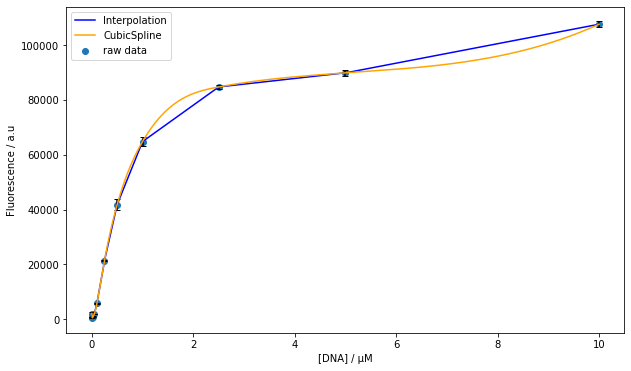

In [13]:
plt.figure(figsize=figuresize)

plt.scatter(df_binding_coeff["conc DNA"], df_binding_coeff["Average"], 
            label = "raw data")
plt.errorbar(df_binding_coeff["conc DNA"], df_binding_coeff["Average"], 
             yerr=df_binding_coeff["STDEV"], linestyle ="None", color="Black",
            capsize=3, label="_nolegend_")
plt.plot(inter_binding_conc, inter_binding_np, label = "Interpolation", 
         color="Blue")
plt.plot(inter_binding_conc, inter_binding_cs, label = "CubicSpline",
        color="Orange")

plt.legend()
plt.xlabel("[DNA] / µM")
plt.ylabel("Fluorescence / a.u")
plt.show()

## Fitting

### Read in the data from the fitting.txt file, plot them

Instead, I am using my own data and fitting it with a custom function for binding coefficients

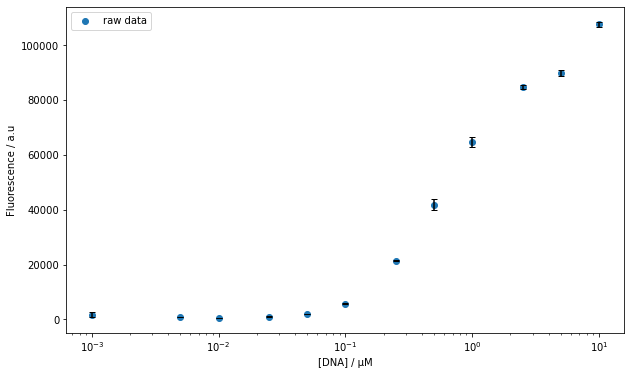

In [20]:
plt.figure(figsize=figuresize)

plt.xscale("log")
plt.scatter(df_binding_coeff["conc DNA"], df_binding_coeff["Average"], 
            label = "raw data")
plt.errorbar(df_binding_coeff["conc DNA"], df_binding_coeff["Average"], 
             yerr=df_binding_coeff["STDEV"], linestyle ="None", color="Black",
            capsize=3, label="_nolegend_")

plt.legend()
plt.xlabel("[DNA] / µM") 
plt.ylabel("Fluorescence / a.u")
plt.show()

### Fit the data with a polynomial using numpy.polyfit

In [14]:
def Kd_fit(At, C0, C1, Kd, Bt=1):
    return (C1 * ((((At+Bt+Kd)-np.sqrt(((At+Bt+Kd)**2)-4*(At*Bt)))/2)/Bt)) + C0

In [27]:
initial_guess = [1000, 90000, 0.5]
bounds = ([0, 0, 0], [7000, 120000, 10])
cont_conc = np.linspace(0, 10, 1000)

In [28]:
params, covariance = curve_fit(Kd_fit, xdata=df_binding_coeff["conc DNA"], 
                               ydata=df_binding_coeff["Average"],
                               p0=initial_guess, bounds=bounds)

C0_fit_no_Eco2, C1_fit_no_Eco2, Kd_fit_no_Eco2 = params

print(f"Fitted C0: {C0_fit_no_Eco2}")
print(f"Fitted C1: {C1_fit_no_Eco2}")
print(f"Fitted Kd: {Kd_fit_no_Eco2}")

Fitted C0: 103.21643285740855
Fitted C1: 102144.94840196056
Fitted Kd: 0.23680355795085803


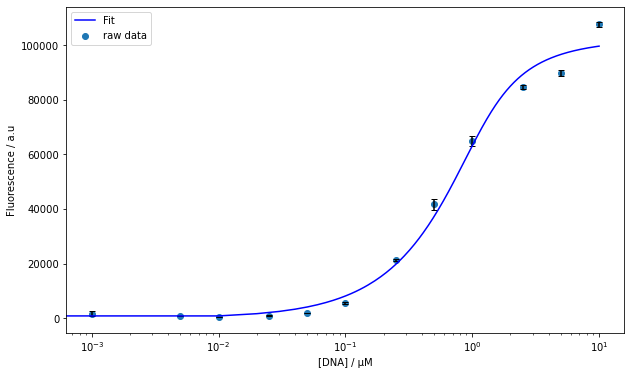

In [23]:
plt.figure(figsize=figuresize)

plt.xscale("log")
plt.scatter(df_binding_coeff["conc DNA"], df_binding_coeff["Average"], 
            label = "raw data")
plt.errorbar(df_binding_coeff["conc DNA"], df_binding_coeff["Average"], 
             yerr=df_binding_coeff["STDEV"], linestyle ="None", color="Black",
            capsize=3, label="_nolegend_")
plt.plot(cont_conc, Kd_fit(cont_conc, C0_fit_no_Eco2, C1_fit_no_Eco2, 
                           Kd_fit_no_Eco2), label="Fit", color='blue')

plt.legend()
plt.xlabel("[DNA] / µM") 
plt.ylabel("Fluorescence / a.u")
plt.show()

### Using scipy curve fit, try fitting the data with a single exponential and a superposition of two exponentials

### Bonus: Compare the chi-square values (sum of quadratic distances of datapoints to fit) for all three fits performed

In [35]:
chisquare = np.sum((df_binding_coeff["Average"] - Kd_fit(df_binding_coeff["conc DNA"], 
                                                         C0_fit_no_Eco2, C1_fit_no_Eco2, 
                                                         Kd_fit_no_Eco2)) ** 2)

print(chisquare)

170246862.03612804


In [37]:
chisquare_per_value = chisquare / len(df_binding_coeff["conc DNA"])

print(chisquare_per_value)

14187238.50301067


## Advanced fitting

### Read in the gaussians_2d file, the y_axis and x_axis and plot them as a contour plot

### Fit the sum of 2 Gaussians to the data  in the file by generating a 2D loss function, plot this loss function and minimize it.

## Filtering

### Read in the data from the filtering.txt file, plot them

### Apply the savgol and moving average filter to the data. Adjust the options (window sizes, polynomial degrees etc.).

### Apply the fourier filter

### Bonus: Create an interactive plot with all the filter methods, the noisy data and the noise free data where you can choose which lines to look at so you can compare better

### Adapt the fourier solution from the lecture to give you the frequencies and amplitudes of the cleaned signal